<a href="https://colab.research.google.com/github/ef-estu/detec-rost-iniciante/blob/main/projeto_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

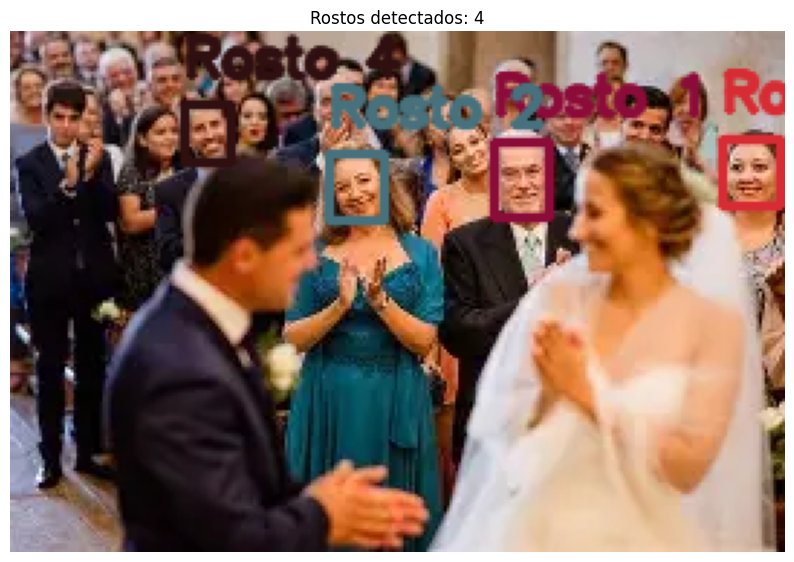

In [1]:
# ============================
# INSTALAÇÃO (necessário no Colab)
# ============================
!pip install opencv-python-headless matplotlib requests

import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import random
import os

# ============================
# 1. Baixar imagem da Web
# ============================
def baixar_imagem(url):
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        img_array = np.frombuffer(resp.content, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        return img
    except:
        print("Erro ao baixar imagem")
        return None

# ============================
# 2. Baixar modelo DNN (Google Colab)
# ============================
def baixar_modelos():
    if not os.path.exists("deploy.prototxt.txt"):
        !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
        !mv deploy.prototxt deploy.prototxt.txt

    if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
        !wget -q https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# ============================
# 3. Carregar modelo DNN
# ============================
def carregar_modelo():
    baixar_modelos()

    prototxt = "deploy.prototxt.txt"
    caffemodel = "res10_300x300_ssd_iter_140000.caffemodel"

    net = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    return net

# ============================
# 4. Detectar rostos com DNN
# ============================
def detectar_rostos_dnn(img, net, conf_min=0.75):
    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(
        cv2.resize(img, (300, 300)),
        1.0,
        (300, 300),
        (104.0, 177.0, 123.0)
    )

    net.setInput(blob)
    deteccoes = net.forward()

    faces = []
    for i in range(0, deteccoes.shape[2]):
        confianca = deteccoes[0, 0, i, 2]

        if confianca >= conf_min:
            box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype("int")

            w_box = x2 - x1
            h_box = y2 - y1

            faces.append((x1, y1, w_box, h_box))

    return faces

# ============================
# 5. Desenhar retângulos
# ============================
def desenhar_rostos(img, faces):
    img_copy = img.copy()
    random.seed(42)

    for i, (x, y, w, h) in enumerate(faces):
        cor = tuple(random.randint(0, 255) for _ in range(3))
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), cor, 2, cv2.LINE_AA)
        cv2.putText(img_copy, f"Rosto {i+1}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, cor, 2, cv2.LINE_AA)

    return img_copy

# ============================
# 6. Exibir imagem no Colab
# ============================
def exibir_imagem(img, titulo="Imagem"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(titulo)
    plt.axis("off")
    plt.show()

# ============================
# 7. Execução
# ============================

# URL da imagem
url = "https://th.bing.com/th/id/OIP.G8-1NYncJnlCl13_kGGG9gHaE8?w=268&h=180&c=7&r=0&o=7&pid=1.7&rm=3"

img = baixar_imagem(url)
if img is None:
    raise SystemExit("Não foi possível carregar a imagem!")

# Redimensionamento opcional
altura_max = 800
escala = altura_max / img.shape[0]
img_resized = cv2.resize(img, (int(img.shape[1] * escala), altura_max)) if escala < 1 else img

# Carregar IA
net = carregar_modelo()

# Detectar rostos
faces = detectar_rostos_dnn(img_resized, net)

# Desenhar resultados
img_final = desenhar_rostos(img_resized, faces)

# Mostrar no Colab
exibir_imagem(img_final, titulo=f"Rostos detectados: {len(faces)}")
